In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
import time
from tqdm import tqdm
from skimage.transform import resize

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

W0324 19:48:06.321156 140004534728512 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


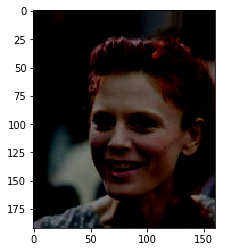

In [52]:
def normed(x):
    return x - 0.5

def pic(n):
    img = plt.imread("../data/img_align_celeba/" + "%.6d.jpg" % (n + 1))
    img = normed(resize(img, (192, 160)))
    return img

img = pic(1)
plt.imshow(img);

In [55]:
def build_generator(noise_dim=100, std=0.02):
    init = RandomNormal(stddev=std)
    inp = layers.Input(shape=(noise_dim,))
    
    X = layers.Dense(6*5*1024, kernel_initializer=init)(inp)
    X = layers.Reshape((6, 5, 1024))(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Conv2DTranspose(512, 5, strides=(2, 2), padding="same", kernel_initializer=init)(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Conv2DTranspose(256, 5, strides=(2, 2), padding="same", kernel_initializer=init)(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Conv2DTranspose(128, 5, strides=(2, 2), padding="same", kernel_initializer=init)(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Conv2DTranspose(64, 5, strides=(2, 2), padding="same", kernel_initializer=init)(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Conv2DTranspose(3, 5, strides=(2, 2), padding="same", kernel_initializer=init, 
                               activation='tanh')(X)
    return Model(inp, X)

In [70]:
# gen = build_generator()
gen = tf.keras.models.load_model('generator.hdf5')
# gen.summary()

W0324 20:49:06.112232 140004534728512 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [57]:
def build_discriminator(slope=0.2, std=0.02, rate=0.2):
    init = RandomNormal(stddev=std)
    inp = layers.Input(shape=img.shape)
    
    X = layers.Conv2D(512, 5, strides=(2, 2), padding='same', kernel_initializer=init)(inp)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Conv2D(256, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Conv2D(128, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Conv2D(64, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Flatten()(X)
    X = layers.Dense(1)(X)
    return Model(inp, X)

In [71]:
discr = build_discriminator()
# discr.summary()

In [59]:
def build_encoder(slope=0.2, std=0.02, rate=0.2):
    init = RandomNormal(stddev=std)
    inp = layers.Input(shape=img.shape)
    
    X = layers.Conv2D(512, 5, strides=(2, 2), padding='same', kernel_initializer=init)(inp)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Conv2D(256, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Conv2D(128, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Conv2D(64, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Flatten()(X)
    X = layers.Dense(100, activation='tanh')(X)
    return Model(inp, X)

In [72]:
encoder = build_encoder()
# encoder.summary()

In [61]:
def build_critic():
    inp = layers.Input(shape=img.shape)
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img.shape)
    X = vgg(inp)
    X = layers.Flatten()(X)
    return Model(inp, X)

In [62]:
critic = build_critic()
critic.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 192, 160, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 6, 5, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 15360)             0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [73]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output, enc_output):
    real_loss = cross_entropy(0.9 * tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    enc_loss = cross_entropy(tf.zeros_like(enc_output), enc_output)
    total_loss = real_loss + fake_loss + enc_loss
    return total_loss

def generator_loss(fake_output, enc_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    enc_loss = cross_entropy(tf.ones_like(enc_output), enc_output)
    return fake_loss + enc_loss

In [74]:
lrate=0.0002
beta1=0.5
gen_optimizer = tf.keras.optimizers.Adam(lrate, beta1)
discr_optimizer = tf.keras.optimizers.Adam(lrate, beta1)
enc_optimizer = tf.keras.optimizers.Adam(lrate, beta1)
cr_optimizer = tf.keras.optimizers.Adam(lrate, beta1)

In [75]:
noise_dim = 100

@tf.function
def train_step(images):
    noise_batch=32
    noise = tf.random.normal([noise_batch, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape, tf.GradientTape() as enc_tape:
        encoded = encoder(images, training=True)
        fake_images = gen(noise, training=True)
        dec_images = gen(encoded, training=True)
        
        real_output = discr(images, training=True)
        fake_output = discr(fake_images, training=True)
        dec_output = discr(dec_images, training=True)
        
        rec_loss = mse(images, dec_images)
        gen_loss = generator_loss(fake_output, dec_output) + rec_loss
        discr_loss = discriminator_loss(real_output, fake_output, dec_output)
        
        gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
        discr_grads = discr_tape.gradient(discr_loss, discr.trainable_variables)
        enc_grads = enc_tape.gradient(rec_loss, encoder.trainable_variables)
        
    gen_optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
    discr_optimizer.apply_gradients(zip(discr_grads, discr.trainable_variables))
    enc_optimizer.apply_gradients(zip(enc_grads, encoder.trainable_variables))
    return gen_loss, discr_loss

In [76]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.ids = np.arange(200_00)
        self.on_epoch_end()
        
    def __getitem__(self, index):
        ids = self.ids[self.batch_size * index : self.batch_size * (index + 1)]
        X = np.empty((self.batch_size, *img.shape), dtype=np.float32)
        for i, _id in enumerate(ids):
            X[i] = pic(_id)
        return X
    
    def __len__(self):
        return len(self.ids) // self.batch_size
    
    def on_epoch_end(self):
        np.random.shuffle(self.ids)

In [77]:
def generate_images(decoder, encoder, idx):
    encoded = encoder.predict(pic(idx).reshape((1, *img.shape)))
    decoded = decoder.predict(encoded)
    fig = plt.figure(figsize=(4,4))
    plt.imshow(decoded[0] + 0.5, cmap='gray')
    plt.axis('off')
    plt.show()

In [78]:
data = DataGenerator(32)

def train(data, epochs):
    for epoch in range(1, epochs + 1):
        start = time.time()
        for i, images in enumerate(data):
            gl, dl = train_step(images)
            if i % 100 == 0:
                display.clear_output(wait=True)
                generate_images(gen, encoder, 1)
                print("Iter %d %s :: %s" % ((i+1), str(gl), str(dl)))
        end = time.time()
        print("Epoch %d took %d secs" % (epoch, end-start))

W0324 21:20:13.877497 140004534728512 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


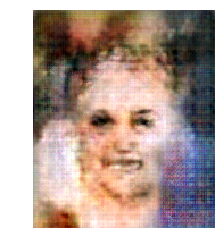

Iter 201 tf.Tensor(3.6512206, shape=(), dtype=float32) :: tf.Tensor(1.454066, shape=(), dtype=float32)


KeyboardInterrupt: 

In [79]:
train(data, epochs=10)

W0324 21:20:55.349707 140004534728512 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


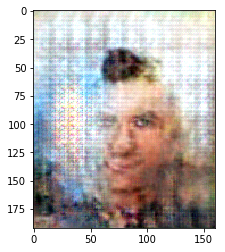

In [91]:
vec = np.random.normal(size=(1, 100))
plt.imshow(gen.predict(vec)[0] + 0.5);

W0324 21:24:10.538991 140004534728512 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0324 21:24:10.556357 140004534728512 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


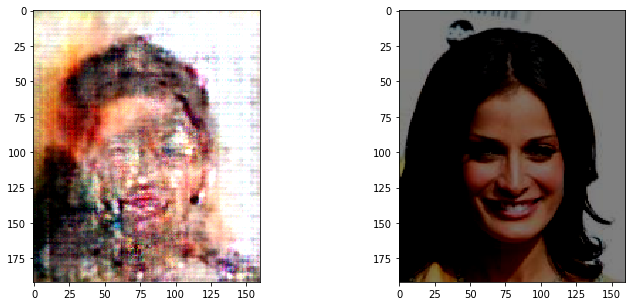

In [102]:
idx = np.random.randint(0, 10000, size=1)
encoded = encoder.predict(pic(idx).reshape((1, *img.shape)))
decoded = gen.predict(encoded)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(decoded[0] + 0.5, cmap='gray')
plt.subplot(122)
plt.imshow(pic(idx))